In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
page_df=pd.read_csv('ab_data.csv')
page_df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


分组（实验组or对照组）、展示的页面版本（新版or旧版），以及该用户是否转化（0-未转化 or 1-转化）

# Data Cleasing


## Check duplicated user_id

In [3]:
print('数据行数：', page_df.shape[0])
print('独立用户数：', page_df.user_id.nunique())

数据行数： 294478
独立用户数： 290584


In [4]:
page_df[page_df.user_id.duplicated(keep=False)].sort_values(by = 'user_id').head(10)

,user_id,timestamp,group,landing_page,converted
230259,630052,2017-01-17 01:16:05.208766,treatment,new_page,0
213114,630052,2017-01-07 12:25:54.089486,treatment,old_page,1
22513,630126,2017-01-14 13:35:54.778695,treatment,old_page,0
251762,630126,2017-01-19 17:16:00.280440,treatment,new_page,0
183371,630137,2017-01-20 02:08:49.893878,control,old_page,0
11792,630137,2017-01-22 14:59:22.051308,control,new_page,0
207211,630320,2017-01-07 18:02:43.626318,control,old_page,0
255753,630320,2017-01-12 05:27:37.181803,treatment,old_page,0
96929,630471,2017-01-07 02:14:17.405726,control,new_page,0
110634,630471,2017-01-23 01:42:51.501851,control,old_page,0


## Remove the rows that have mismatches of group and landing_page
按理来说实验组对应的是老页面，对照对应新页面，对不上的就删了

In [5]:
#page_df['group'] == 'treatment'是bool，mismatch也是bool
mismatch = ((page_df['group'] == 'treatment') != (page_df['landing_page'] == 'new_page'))
print('不匹配数：', mismatch.sum())

不匹配数： 3893


In [6]:
match_df = page_df[~mismatch].copy()  # mismatch~按位取反，就是要match的咯

再次查看行数与独立用户数

In [7]:
print('数据行数：', match_df.shape[0])
print('独立用户数：', match_df.user_id.nunique())

数据行数： 290585
独立用户数： 290584


## Remove duplicated user_id

根据唯一性的要求，用户不被重复计入测试

In [8]:
# 查看重复值
match_df[match_df.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [9]:
# 删
match_df = match_df.drop_duplicates(subset=['user_id'], keep='last')

## Check missing value

In [10]:
match_df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [11]:
# 刷到新页面的用户占比
match_df[match_df.landing_page=="new_page"].shape[0]/match_df.shape[0]

0.5000619442226688

# A/B Testing

先假设检验，统计检验显著后（有差异），再用效应量科恩d值去算效应大小

Null Hypo：**$p_{old}$-$p_{new}$>=0** 

Alternative Hypo：**$p_{old}$-$p_{new}$<0**

## 法一 ：手算

### 算检验统计量z

独立双样本，number of samples > 30,总体的均值和标准差未知，因为中心极限定理，样本均值服从正态分布，总体方差可以用样本方差来估计，用Z-test。(alpha取0.05，其中$p_{c}$是转化率的联合统计。

**$z = \frac {p_{old} - p_{new}} {\sqrt{ \frac{1}{n_{old}} + \frac{1}{n_{new}} \times p_c \times (1 - p_c)}}$**

In [12]:
# 总受试用户数
n_old = match_df[match_df.landing_page=="old_page"].shape[0]
n_new = match_df[match_df.landing_page=="new_page"].shape[0]

# 转化用户数
convert_old = match_df.query('group=="control" & converted==1').shape[0]
convert_new = match_df.query('group=="treatment" & converted==1').shape[0]

# 转化率
p_old = convert_old / n_old
p_new = convert_new / n_new

print('旧版总受试用户数:', n_old, '旧版转化用户数:', convert_old, '旧版转化率:', p_old)
print('新版总受试用户数:', n_new, '新版转化用户数:', convert_new, '新版转化率:', p_new)

旧版总受试用户数: 145274 旧版转化用户数: 17489 旧版转化率: 0.1203863045004612
新版总受试用户数: 145310 新版转化用户数: 17872 新版转化率: 0.12299222352212512


In [13]:
p_c = (convert_old + convert_new)/(n_old + n_new)
print('转化率联合估计:', p_c)

转化率联合估计: 0.12168942543292129


In [14]:
z = (p_old - p_new)/ np.sqrt(p_c*(1 - p_c)*( 1/n_old + 1/n_new))
print('检验统计量z:', z)

检验统计量z: -2.1484056695589


### 查表
Z分布alpha0.05对应的分位数$z_{alpha}$，备择假设是左尾（单侧）

In [15]:
from scipy.stats import norm
z_alpha = norm.ppf(0.05)
# 查表-单侧 双侧的0.05其实是单侧的0.025，即1.96 
z_alpha

-1.6448536269514729

一般取三位为-1.644，拒绝域是{z <= $z_{alpha}$ },z=-2.15落入拒绝域，因此拒绝null hypo.

### 统计检验显著后 算科恩d


**假设检验并不能真正的衡量差异的大小，它只能判断差异是否比随机造成的更大**

统计假设检验报告了假设观察结果的可能性，例如，变量之间没有关联或集合之间没有差异。

如果关联或差异具有统计学意义，则假设检验不会评估效果的大小。

效应量方法是指用于量化实验结果中效应量的一套统计工具，可用于**补充统计假设检验的结果**。

因此，我们在报告假设检验结果的同时，给出**效应的大小**，对比平均值时，衡量效应大小的常见标准之一是科恩d值Cohen's d：

**$d = \frac{样本平均值_{1} - 样本平均值_{2}}{标准差}$**

由于是双独立样本的，用双独立样本的合并标准差pooled standard deviations代替标准差：

**$s = \sqrt{\frac{(n_1 - 1) \times s_1^2  + (n_2 - 1) \times {s_2}^2}{n_1 + n_2 -2}}$**

$n_1$，$n_2$：第一个样本和第二个样本的大小

$s_1$，$s_1$：第一个样本和第二个的标准差


In [16]:
n_old, n_new

(145274, 145310)

In [17]:
p_old, p_new

(0.1203863045004612, 0.12299222352212512)

In [18]:
# 合并标准差
std_old = match_df[match_df.landing_page=="old_page"].converted.std()
std_new = match_df[match_df.landing_page=="new_page"].converted.std()
s = np.sqrt(((n_old - 1)* std_old**2 + (n_new - 1)* std_new**2 ) / (n_old + n_new - 2))
# Cohen's d
d = (p_old - p_new) / s
print('Cohen\'s d为：', d)

Cohen's d为： -0.007970992391336005


## 法二：不手算，用现成的

`stats.proportions_ztest` 计算检验统计量z与p值。[官方文档](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html#statsmodels.stats.proportion.proportions_ztest)

In [19]:
import statsmodels.stats.proportion as sp
z_score, p_value = sp.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print('检验统计量z:', z_score, '，p值:', p_value)

检验统计量z: -2.1484056695589 ，p值: 0.015840771394875417


或者用 `stats.weightstats.ztest` 计算检验统计量z与p值。
[官方文档](https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ztest.html)

In [20]:
import statsmodels.stats.weightstats as sw
z_score1, p_value1 = sw.ztest(match_df.query('landing_page=="old_page"')['converted'], match_df.query('landing_page=="new_page"')['converted'],
                        alternative='smaller')
print('检验统计量z:', z_score1, '，p值:', p_value1)

检验统计量z: -2.148415338961362 ，p值: 0.01584038766094882


## 法三：蒙特卡洛法

其实就是模拟法，用计算机模拟多次抽样，获得分布。

在零假设的前提下，p_old = p_new是一个**临界情况**（即零假设前提下最接近备择假设的情况）。
如果连相等的情况都能拒绝，那么零假设的剩下部分就更能够拒绝了。
取p_old = p_new = p_all

进行一次模拟：
以总体的p_all为新旧版共同的转化率均值，分别进行n_old和n_new次0-1抽样，使模拟的样本大小同ab_data.csv中的样本大小相同。

In [21]:
p_all = match_df.converted.mean()
print('p_all:', p_all)

p_all: 0.12168942543292129


In [22]:
old_page = np.random.choice(2, size=n_old, p=[1-p_all, p_all])
new_page = np.random.choice(2, size=n_new, p=[1-p_all, p_all])
diff = old_page.mean() - new_page.mean()
print('旧版模拟结果：', old_page, '，新版模拟结果：', new_page, '，模拟的转化率差值：', diff)

旧版模拟结果： [0 0 1 ... 0 0 0] ，新版模拟结果： [0 0 0 ... 0 0 0] ，模拟的转化率差值： -0.0006857325053662988


In [23]:
match_diff = match_df[match_df.landing_page=="old_page"]['converted'].mean()-match_df[match_df.landing_page=="new_page"]['converted'].mean()
print('ab_data.csv样本的转化率差值:', match_diff)

ab_data.csv样本的转化率差值: -0.002605919021663919


按照如上方式进行多次模拟，这里我们进行10000次：

In [24]:
diffs=[]
for i in range(10000):
    p_new_diff = np.random.choice(2,size=n_new,p=[1-p_all,p_all]).mean()
    p_old_diff = np.random.choice(2,size=n_old,p=[1-p_all,p_all]).mean()
    diffs.append(p_old_diff - p_new_diff)

实际上每次模拟都得到了一个大小为290584的样本，此处相当于得到了10000个样本。并计算出了每个样本得到的版本转化率差值，将其存储在diffs中。

直方图：若旧版和新版的转化率相等，随机10000次（次数够多，根据大数定律，近似于真实的分布），两者的差值的分布：

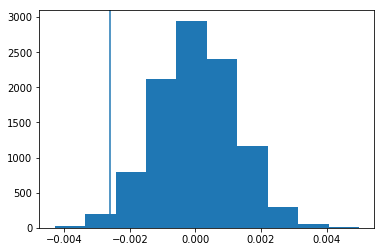

In [25]:
diffs = np.array(diffs)
plt.hist(diffs)
plt.axvline(match_diff)

越靠近两边越极端，竖线是样本ab_data.csv的差值所在位置，落在了很左的地方，竖线左侧的**面积**很小，即发生竖线及竖线左端的情况的可能性很小，也就是说ab_data.csv这个样本，在旧版和新版转化率相等的情况有可能出现，但出现的可能性很小；而竖线右端的情况说明只做了几次A/B测试就很可能得到了零假设所说的极端情况，则零假设很有可能是不成立的。所以反推出，旧版和新版的转化率很有可能不相等。

在diffs列表的数值中，有多大比例小于ab_data.csv中观察到的实际差值？

In [26]:
(diffs < match_diff).mean()
# 这个值是变动的每次跑都不一样，但都差不多接近前几个方法中的p值0.01

0.0164

在$p_{old} = p_{new}$的时候，进行10000次模拟得到的差值中，只有1.48%的比ab_data.csv中的差值更极端。